In [1]:
import pandas as pd
import os
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import shutil
import numpy as np
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall, AUC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, roc_curve, auc, confusion_matrix, classification_report, roc_auc_score, f1_score, recall_score, precision_score, RocCurveDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.ensemble import RandomForestClassifier
from skimage import io, color, transform
import mlflow as mlf
import mlflow.sklearn as mlfsk

# Affichage en ligne des graphiques
%matplotlib inline

Répartition des Classes :
No Tumor : 2000 échantillons
Pituitary : 2000 échantillons
Meningioma : 2000 échantillons
Glioma : 2000 échantillons


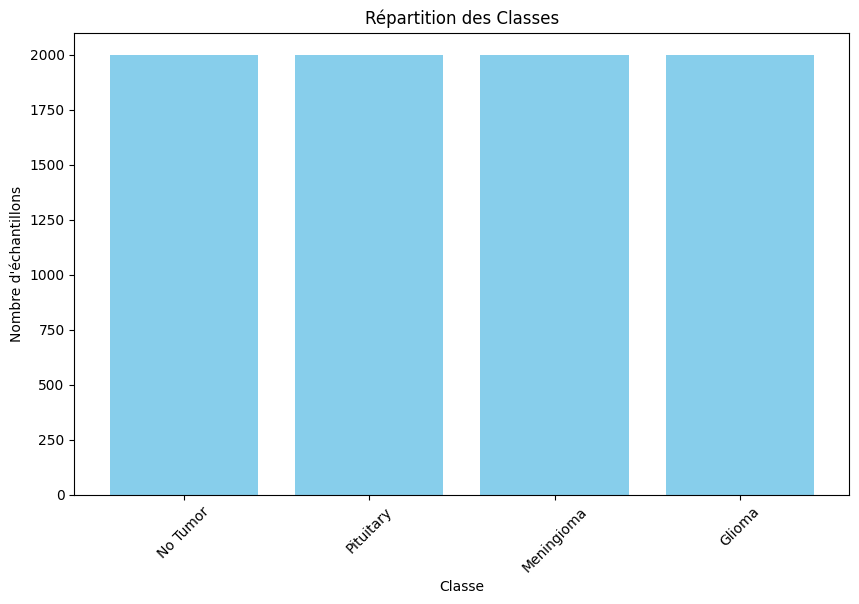

In [2]:
def plot_class_distribution_from_csv(csv_path):
    """
    Affiche la répartition des classes à partir d'un fichier CSV.

    Parameters:
    - csv_path: str, chemin vers le fichier CSV contenant les colonnes 'image_name' et 'target'.
    """
    # Charger le fichier CSV
    df = pd.read_csv(csv_path)

    # Compter le nombre d'échantillons par classe
    class_counts = df['target'].value_counts().sort_index()

    # Mapper les indices des classes à leurs noms
    class_names = {0: "No Tumor", 1: "Pituitary", 2: "Meningioma", 3: "Glioma"}
    class_counts.index = class_counts.index.map(class_names)

    # Afficher la répartition des classes
    print("Répartition des Classes :")
    for class_name, count in class_counts.items():
        print(f"{class_name} : {count} échantillons")

    # Tracer le graphique de distribution des classes
    plt.figure(figsize=(10, 6))
    plt.bar(class_counts.index, class_counts.values, color='skyblue')
    plt.title('Répartition des Classes')
    plt.xlabel('Classe')
    plt.ylabel('Nombre d\'échantillons')
    plt.xticks(rotation=45)
    plt.show()

# Exemple d'appel de la fonction
plot_class_distribution_from_csv('./dataset/balanced_metadata.csv')

In [3]:
def load_images_from_csv(directory, csv_file):
    """
    Charge les images d'un répertoire et les étiquettes d'un fichier CSV.

    Parameters:
    - directory: str, chemin vers le répertoire contenant les images.
    - csv_file: str, chemin vers le fichier CSV contenant les noms d'images et leurs étiquettes.

    Returns:
    - X: numpy array de forme (nombre_échantillons, hauteur*largeur),
         contenant les données des images en vecteurs.
    - y: numpy array de forme (nombre_échantillons,), contenant les étiquettes pour chaque image.
    """
    # Charger le fichier CSV
    metadata = pd.read_csv(csv_file)

    X = []
    y = []

    # Parcourir chaque ligne du CSV
    for index, row in metadata.iterrows():
        image_name = row['image_name']
        target = row['target']

        # Créer le chemin complet vers l'image
        image_path = os.path.join(directory, image_name)

        try:
            # Chargement et prétraitement de l'image
            image = io.imread(image_path)
            image = transform.resize(image, (100, 100, 3))  # Redimensionner l'image
            image = color.rgb2gray(image)  # Convertir l'image en niveaux de gris
            X.append(image.flatten())  # Aplatir l'image en un vecteur
            y.append(target)  # Ajouter l'étiquette de l'image
        except Exception as e:
            print(f"Erreur lors du chargement de {image_path}: {e}")

    X = np.array(X)
    y = np.array(y)

    return X, y

# Chemin vers le répertoire contenant les images et le fichier CSV
dataset_directory = "./dataset/balanced_dataset"
csv_file = "./dataset/balanced_metadata.csv"

# Charger les données
X, y = load_images_from_csv(dataset_directory, csv_file)

# Division des données en ensembles d'entraînement et de test (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Define the Random Forest model
model = RandomForestClassifier()

# Train the model on the training data
model.fit(X_train, y_train)

# Evaluate the model on the test data and print the accuracy
accuracy = model.score(X_test, y_test)
print(f"Accuracy of Random Forest: {accuracy}")

In [4]:
mlf.set_tracking_uri("http://127.0.0.1:5000")

# Set up a new experiment
mlf.set_experiment("Brain_Tumor_Classification_Random_Forest")

<Experiment: artifact_location='mlflow-artifacts:/286751057660019599', creation_time=1733869508157, experiment_id='286751057660019599', last_update_time=1733869508157, lifecycle_stage='active', name='Brain_Tumor_Classification_Random_Forest', tags={}>

In [ ]:
# Define the parameter grid
param_grid = {
    'n_estimators': range(10, 201, 20),
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt', 'log2']
}

# Create combinations of hyperparameters
grid = list(ParameterGrid(param_grid))

# Iterate over all combinations of hyperparameters
for params in grid:
    with mlf.start_run():
        # Initialize the Random Forest model with current parameters
        model = RandomForestClassifier(
            n_estimators=params['n_estimators'],
            max_depth=params['max_depth'],
            min_samples_split=params['min_samples_split'],
            max_features=params['max_features'],
            random_state=42
        )

        # Train the model
        model.fit(X_train, y_train)

        # Predict on test data
        y_pred = model.predict(X_test)

        # Calculate accuracy
        accuracy = accuracy_score(y_test, y_pred)

        # Log parameters
        mlf.log_param("n_estimators", params['n_estimators'])
        mlf.log_param("max_depth", params['max_depth'])
        mlf.log_param("min_samples_split", params['min_samples_split'])
        mlf.log_param("max_features", params['max_features'])

        # Log accuracy
        mlf.log_metric("accuracy", accuracy)

        # Log the model
        mlfsk.log_model(model, "random_forest_model")

        print(f"Logged run with parameters: {params} and accuracy: {accuracy}")


In [ ]:
model = RandomForestClassifier(random_state=42)

# Start an MLflow run
with mlf.start_run():

    nEstimators=30
    maxDepth=None
    minSamplesSplit=2
    maxFeatures='sqrt'
    
    # Train the Random Forest model
    model = RandomForestClassifier(n_estimators=nEstimators, max_depth=maxDepth, min_samples_split=minSamplesSplit, max_features=maxFeatures, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Log parameters and metrics
    mlf.log_param("n_estimators", nEstimators)
    mlf.log_param("max_depth", maxDepth)
    mlf.log_param("min_samples_split", minSamplesSplit)
    mlf.log_param("max_features", maxFeatures)
    mlf.log_metric("accuracy", accuracy)
    mlf.log_metric("precision", precision)
    mlf.log_metric("recall", recall)
    mlf.log_metric("f1_score", f1)

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")

    # Save and log the confusion matrix plot as an artifact
    cm_filepath = "confusion_matrix_rf.png"
    plt.savefig(cm_filepath)
    mlf.log_artifact(cm_filepath)

    print("Confusion matrix plot logged as an artifact.")

In [ ]:
with mlf.start_run(nested=True):
    # Define the model URI
    model_uri = f"runs:/{mlf.active_run().info.run_id}/model_brain_tumor_classifier"

    # Ensure input example is simple and serializable
    input_example = X_train[:1]  # First row of training data

    # Log the Random Forest model
    mlf.sklearn.log_model(
        sk_model=model,
        artifact_path="model_brain_tumor_classifier",
        input_example=input_example
    )

    # Register the model
    mlf.register_model(model_uri, "BrainTumorClassifierBestModel")

Accuracy of Random Forest: 0.919375


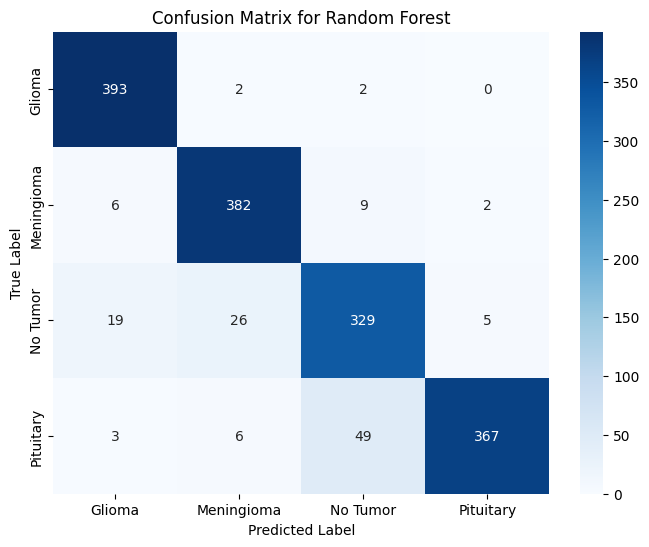

In [5]:
# Define the Random Forest model
model = RandomForestClassifier(n_estimators=30, max_depth=None, min_samples_split=2, max_features='sqrt', random_state=42)

# Train the model on the training data
model.fit(X_train, y_train)

# Evaluate the model on the test data and print the accuracy
accuracy = model.score(X_test, y_test)
print(f"Accuracy of Random Forest: {accuracy}")

# Predict on the test data
y_pred = model.predict(X_test)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using Seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Glioma", "Meningioma", "No Tumor", "Pituitary"], yticklabels=["Glioma", "Meningioma", "No Tumor", "Pituitary"])
plt.title("Confusion Matrix for Random Forest")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

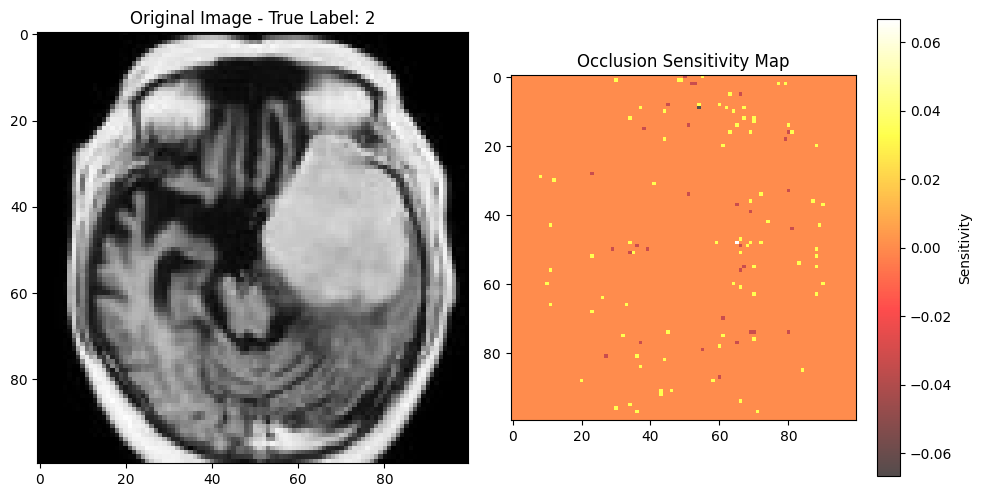

In [6]:
# Adjust based on the original image dimensions before flattening
original_image_shape = (100, 100)  # Replace with your image's actual dimensions

def occlusion_sensitivity(model, image, mask_size, feature_names):
    """
    Compute occlusion sensitivity for a given image.
    
    Parameters:
        model: Trained Random Forest model.
        image: Input image (as a flattened feature vector).
        mask_size: Size of the occlusion mask.
        feature_names: Names or indices of image features.
    
    Returns:
        Sensitivity map (same shape as the input image).
    """
    original_prediction = model.predict_proba([image])[0]
    sensitivity_map = np.zeros(len(feature_names))
    
    for i in range(len(feature_names)):
        # Create a copy of the image with one feature masked
        masked_image = image.copy()
        masked_image[i] = 0  # Mask the feature
        
        # Predict with the masked image
        masked_prediction = model.predict_proba([masked_image])[0]
        
        # Compute sensitivity as the change in the target class probability
        sensitivity_map[i] = original_prediction.max() - masked_prediction.max()
    
    # Reshape the sensitivity map back to the image shape
    return sensitivity_map.reshape(original_image_shape)

# Example use case
image_index = 0
image = X_test[image_index]  # Replace with a specific image from your test set
label = y_test[image_index]

# Generate occlusion sensitivity map
sensitivity_map = occlusion_sensitivity(model, image, mask_size=1, feature_names=range(X_train.shape[1]))

# Visualize the sensitivity map
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image.reshape(original_image_shape), cmap='gray')  # Adjust dimensions for your images
plt.title(f"Original Image - True Label: {label}")

plt.subplot(1, 2, 2)
plt.imshow(sensitivity_map, cmap='hot', alpha=0.7)
plt.colorbar(label="Sensitivity")
plt.title("Occlusion Sensitivity Map")

plt.tight_layout()
plt.show()


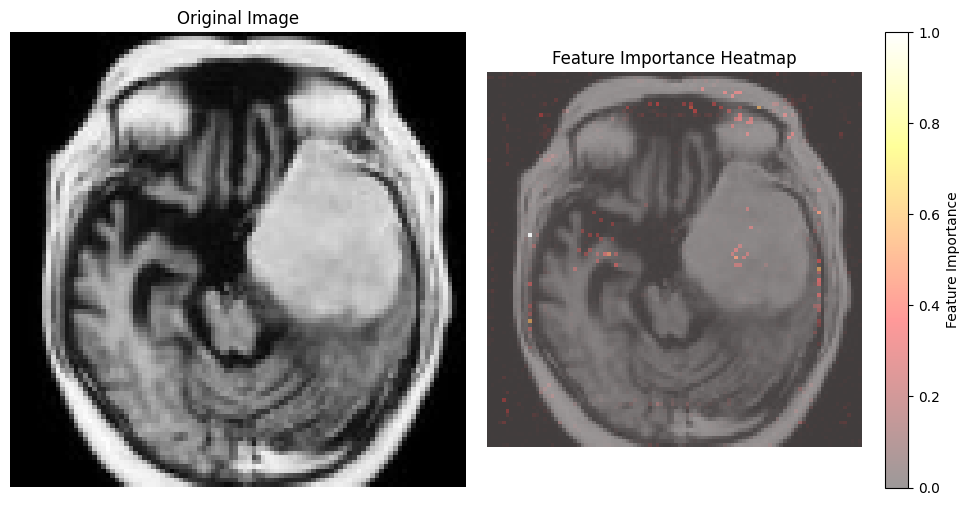

In [7]:
# Extract feature importances
feature_importances = model.feature_importances_

# Reshape feature importances to match the original image dimensions
importance_map = feature_importances.reshape(original_image_shape)

# Normalize the importance map for better visualization
importance_map = (importance_map - np.min(importance_map)) / (np.max(importance_map) - np.min(importance_map))

# Select an image to overlay the heatmap
image_index = 0
original_image = X_test[image_index].reshape(original_image_shape)  # Adjust for your image dimensions

# Plot the original image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(original_image, cmap='gray')
plt.title("Original Image")
plt.axis("off")

# Plot the feature importance heatmap overlay
plt.subplot(1, 2, 2)
plt.imshow(original_image, cmap='gray', alpha=0.6)  # Original image in the background
plt.imshow(importance_map, cmap='hot', alpha=0.4)  # Heatmap overlay
plt.colorbar(label="Feature Importance")
plt.title("Feature Importance Heatmap")
plt.axis("off")

plt.tight_layout()
plt.show()

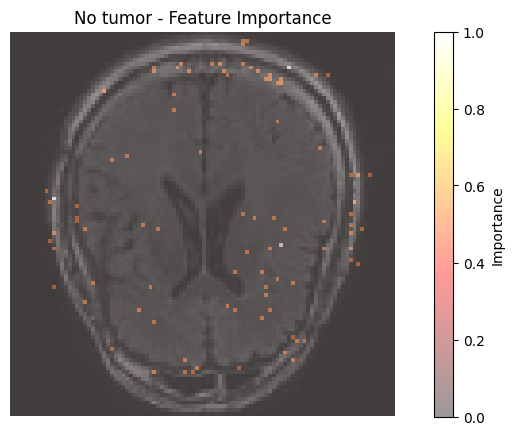

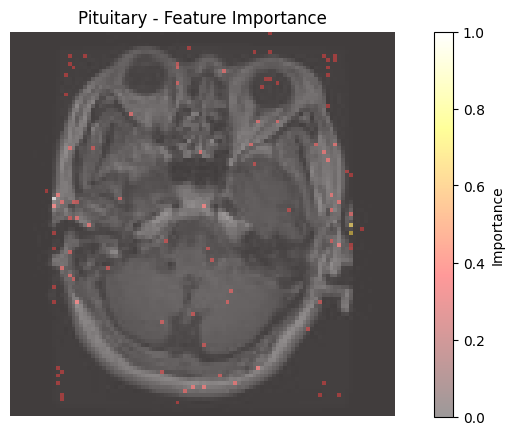

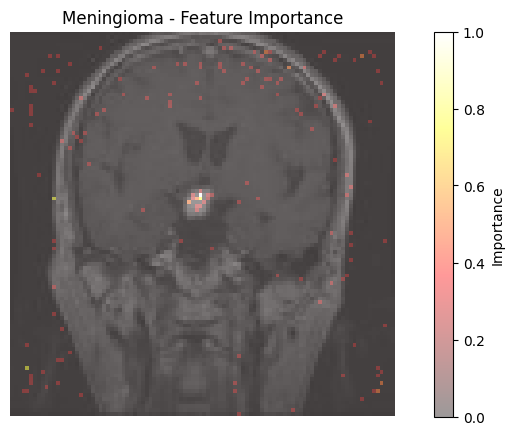

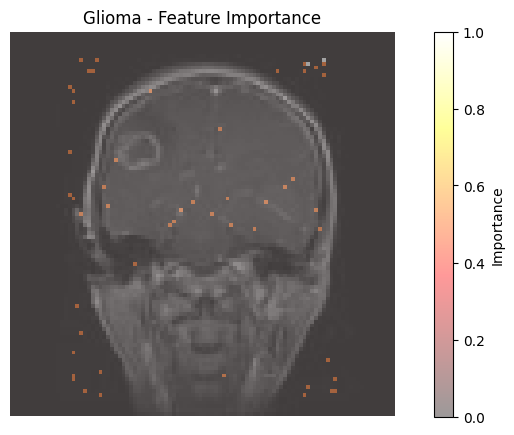

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

# Define class mapping
class_mapping = {
    'No tumor': 0,
    'Pituitary': 1,
    'Meningioma': 2,
    'Glioma': 3
}

# Define the class labels
classes = list(class_mapping.keys())

# Function to calculate the class-specific importance map
def class_specific_importance(model, image, class_idx, original_image_shape):
    """
    Calculate the feature importance map for a specific class.
    
    Parameters:
        model: Trained Random Forest model.
        image: Flattened input image (array).
        class_idx: The index of the class to calculate importance for.
        original_image_shape: Shape of the image (e.g., (28, 28)).
    
    Returns:
        Importance map for the specified class.
    """
    # Original prediction probabilities
    original_probs = model.predict_proba([image])[0]
    original_class_prob = original_probs[class_idx]
    
    # Create a map to store the sensitivity for each feature
    importance_map = np.zeros(image.shape)
    
    for i in range(len(image)):
        # Mask the feature (pixel)
        masked_image = image.copy()
        masked_image[i] = 0  # Set the pixel to 0
        
        # Prediction after masking the feature
        masked_probs = model.predict_proba([masked_image])[0]
        masked_class_prob = masked_probs[class_idx]
        
        # The change in probability for this class after occluding the feature
        importance_map[i] = abs(original_class_prob - masked_class_prob)
    
    # Reshape the importance map to match the original image shape
    return importance_map.reshape(original_image_shape)

# Example: Assuming X_train and y_train are your training data and labels
# Make sure that X_train is already reshaped into appropriate image dimensions (e.g., (100, 100))

# Train the Random Forest model
model = RandomForestClassifier(n_estimators=30, max_depth=None, min_samples_split=2, max_features='sqrt', random_state=42)
model.fit(X_train, y_train)

# Plot heatmaps for each class
for class_name in classes:
    class_idx = class_mapping[class_name]
    
    # Get the indices of images belonging to this class
    class_indices = np.where(y_train == class_idx)[0]
    
    # Choose a random image from this class
    image_index = class_indices[0]
    
    # Get the image of the class and reshape it
    original_image = X_train[image_index].reshape((100, 100))  # Adjust to your image dimensions
    
    # Generate class-specific importance map
    importance_map = class_specific_importance(model, X_train[image_index], class_idx, (100, 100))
    
    # Normalize the importance map for visualization
    importance_map = (importance_map - np.min(importance_map)) / (np.max(importance_map) - np.min(importance_map))
    
    # Plot the heatmap overlay
    plt.figure(figsize=(10, 5))
    plt.imshow(original_image, cmap='gray', alpha=0.6)  # Original image in the background
    plt.imshow(importance_map, cmap='hot', alpha=0.4)  # Heatmap overlay
    plt.title(f"{class_name} - Feature Importance")
    plt.axis('off')
    plt.colorbar(label="Importance")
    plt.show()
